In [ ]:
# Install xgboost in notebook instance.
!pip install xgboost==1.2

In [1287]:
# Import required dependencies
import boto3
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb_lib
from sklearn.linear_model import LogisticRegression

import sklearn

In [1331]:
# Readind data
bucket_name = 'finance-factoring-ml-dev'

df = pd.read_csv('s3://{}/data/all.csv'.format(bucket_name))
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,FechaPago
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,1939.0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,1638.0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,1551.0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,2226.0
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,2166.0


# 5. Prepare dataframes for modeling approaches

Build target column "PaidLate"
> * 0: Invoice is paid on time
> * 1: Invoice is paid late

In [1332]:
def const_paidLate(df):
    df['PaidLate'] = (df['FechaPago'] > df['FechaVencimiento'])*1
    return df

df = const_paidLate(df)

df.drop("FechaPago", axis=1, inplace=True)

In [1335]:
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,PaidLate
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,1
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,0


In [1337]:
df.PaidLate.sum()

5776

Separate target for predictions

In [1338]:
X = df.drop(['PaidLate'], axis=1)
y = df.PaidLate

In [1339]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (14966, 8)
Test dataset shape:  (3742, 8)


## 5.1 Decision Tree Classifier

The Accuracy for DecisionTreeClassifier is:  89  %


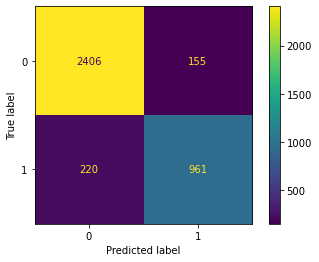

In [1340]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

predicted_tree = tree.predict(X_test)

ac_tree = accuracy_score(y_test, predicted_tree)
print('The Accuracy for DecisionTreeClassifier is: ', int(ac_tree * 100), " %")

cm = confusion_matrix(y_test, predicted_tree, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()

## 5.2 XGBoost Classifier

The Accuracy for XGBClassifier is:  87  %


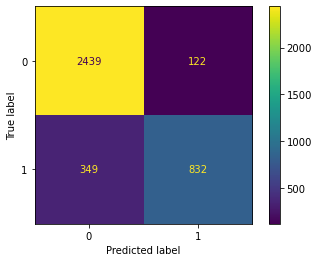

In [1341]:
xgb = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    max_depth=3,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    verbosity=0,
                    use_label_encoder=False)

xgb = xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)

ac_xgb = accuracy_score(y_test, predicted_xgb)
print('The Accuracy for XGBClassifier is: ', int(ac_xgb * 100), " %")

cm = confusion_matrix(y_test, predicted_xgb, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()

## 5.3 LogisticRegression

The Accuracy for LogisticRegression is:  70  %


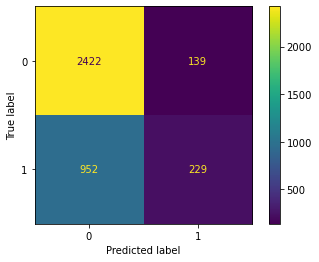

In [1342]:
logr = LogisticRegression(random_state=0,solver='liblinear',penalty='l1',C=100,class_weight=None,max_iter=250)
logr.fit(X_train, y_train)

predicted_logr = logr.predict(X_test)
ac_logr = accuracy_score(y_test, predicted_logr)
print('The Accuracy for LogisticRegression is: ', int(ac_logr * 100), " %")

cm = confusion_matrix(y_test, predicted_logr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_)
disp.plot()

## 5.4 Compare models output

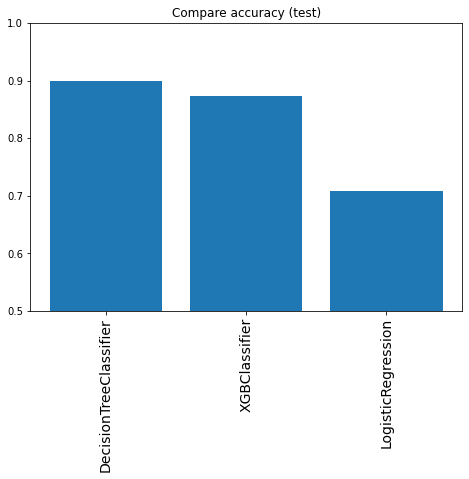

In [1343]:
accuracies = [ac_tree, ac_xgb, ac_logr]
models_name = ['DecisionTreeClassifier', 'XGBClassifier', 'LogisticRegression']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models_name,accuracies)
_ = plt.xticks(rotation=90,fontsize=14)
plt.title('Compare accuracy (test)')
plt.ylim(0.50, 1.0)
plt.show()